In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
sys.path.append('../')

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

# rom bikesharing.ml_logic.model import get_folds, train_test_indices
# from bikesharing.interface.main import *
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.preprocessing import OneHotEncoder

In [12]:
df_X = pd.read_csv('X_processed_from_2019_to_2022.csv')
df_y = pd.read_csv('y_processed_from_2019_to_2022.csv')

In [13]:
df_X.head(3)

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,is_holiday,is_weekend
0,0.355408,1.000000,0.342007,0.227848,0.017391,0.629410,0.982963,0.75,0.933013,0.600779,0.989739,1,0
1,0.357616,0.987013,0.340149,0.245570,0.008696,0.750000,0.933013,0.75,0.933013,0.600779,0.989739,1,0
2,0.359823,1.000000,0.336431,0.303797,0.017391,0.853553,0.853553,0.75,0.933013,0.600779,0.989739,1,0


In [14]:
df_y.head(3)

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,3.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [15]:
print(df_X.shape)
df_X.columns

(35040, 13)


Index(['temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'is_holiday', 'is_weekend'],
      dtype='object')

In [16]:
print(df_y.shape)
df_y.columns

(35040, 34)


Index(['Altstadt-Lehel', 'Au - Haidhausen', 'Aubing-Lochhausen-Langwied',
       'Berg am Laim', 'Bogenhausen', 'Feldmoching', 'Hadern', 'Harlaching',
       'Hasenbergl-Lerchenau Ost', 'Laim', 'Lochhausen',
       'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Milbertshofen-Am Hart',
       'Moosach', 'Neuhausen-Nymphenburg', 'Obergiesing', 'Obermenzing',
       'Obersendling', 'Pasing', 'Pasing-Obermenzing', 'Ramersdorf-Perlach',
       'Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe', 'Sendling',
       'Sendling-Westpark', 'Südgiesing', 'Thalkirchen', 'Trudering',
       'Trudering-Riem', 'Untergiesing', 'Untergiesing-Harlaching',
       'Untermenzing-Allach'],
      dtype='object')

In [17]:
35040*34

1191360

In [18]:
# Prepare X
district_names = df_y.columns

# Repeat each row of X for each district name
X_repeated = pd.DataFrame(np.repeat(df_X.values, len(district_names), axis=0), columns=df_X.columns)

# Create a new DataFrame with repeated district names
district_df = pd.DataFrame({'Districts': district_names})

# Repeat the district names to match the number of rows in X_repeated
district_df_repeated = pd.DataFrame(np.tile(district_df['Districts'].values, len(df_X)), columns=['Districts'])

# Concatenate X_repeated and district_df along the columns
X = pd.concat([X_repeated, district_df_repeated], axis=1)

print(X.shape)
print(X['Districts'].head(50))

(1191360, 14)
0                   Altstadt-Lehel
1                  Au - Haidhausen
2       Aubing-Lochhausen-Langwied
3                     Berg am Laim
4                      Bogenhausen
5                      Feldmoching
6                           Hadern
7                       Harlaching
8         Hasenbergl-Lerchenau Ost
9                             Laim
10                      Lochhausen
11    Ludwigsvorstadt-Isarvorstadt
12                     Maxvorstadt
13           Milbertshofen-Am Hart
14                         Moosach
15           Neuhausen-Nymphenburg
16                     Obergiesing
17                     Obermenzing
18                    Obersendling
19                          Pasing
20              Pasing-Obermenzing
21              Ramersdorf-Perlach
22              Schwabing-Freimann
23                  Schwabing-West
24                Schwanthalerhöhe
25                        Sendling
26               Sendling-Westpark
27                      Südgiesing
28    

In [19]:
# Flatten y
y = df_y.stack().reset_index(level=1, drop=True).reset_index(drop=True).to_frame()
y = y.rename(columns={0: 'Target'})
print(y.shape)
print(y.head())

(1191360, 1)
   Target
0     1.0
1     0.0
2     0.0
3     0.0
4     0.0


In [20]:
y.max()

Target    121.0
dtype: float64

In [21]:
y.isnull().sum()

Target    0
dtype: int64

In [22]:
X.head(3)

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,is_holiday,is_weekend,Districts
0,0.355408,1.0,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,0.989739,1.0,0.0,Altstadt-Lehel
1,0.355408,1.0,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,0.989739,1.0,0.0,Au - Haidhausen
2,0.355408,1.0,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,0.989739,1.0,0.0,Aubing-Lochhausen-Langwied


In [23]:
# One hot encode 'districts' column in X
district_ohe = OneHotEncoder(sparse_output=False)

# Fit encoder
district_ohe.fit(X[['Districts']])

# Apply one-hot encoding and add the encoded columns to the DataFrame
encoded_columns = district_ohe.get_feature_names_out()
encoded_values = district_ohe.transform(X[['Districts']])
X[encoded_columns] = encoded_values
X.drop(columns=['Districts'] , inplace=True)

# Update the column names in df without the prefix 'district_'
column_names = [column.split('Districts_', 1)[-1] for column in X.columns]
X.columns = column_names
print(X.shape)
print(X.columns)

(1191360, 47)
Index(['temperature_2m', 'relativehumidity_2m', 'apparent_temperature',
       'windspeed_10m', 'precipitation', 'hour_sin', 'hour_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'is_holiday', 'is_weekend',
       'Altstadt-Lehel', 'Au - Haidhausen', 'Aubing-Lochhausen-Langwied',
       'Berg am Laim', 'Bogenhausen', 'Feldmoching', 'Hadern', 'Harlaching',
       'Hasenbergl-Lerchenau Ost', 'Laim', 'Lochhausen',
       'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt', 'Milbertshofen-Am Hart',
       'Moosach', 'Neuhausen-Nymphenburg', 'Obergiesing', 'Obermenzing',
       'Obersendling', 'Pasing', 'Pasing-Obermenzing', 'Ramersdorf-Perlach',
       'Schwabing-Freimann', 'Schwabing-West', 'Schwanthalerhöhe', 'Sendling',
       'Sendling-Westpark', 'Südgiesing', 'Thalkirchen', 'Trudering',
       'Trudering-Riem', 'Untergiesing', 'Untergiesing-Harlaching',
       'Untermenzing-Allach'],
      dtype='object')


In [24]:
all_data = pd.concat([X, y], axis=1)
all_data.head(3)

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,...,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach,Target
0,0.355408,1.0,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.355408,1.0,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.355408,1.0,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
all_data.shape

(1191360, 48)

In [ ]:
# Add day of the week feature
# (Remove unneccessary columns)
# Split X and y again

## XGBoost

In [26]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Aubing-Lochhausen-Langwied', 'Berg am Laim', 'Bogenhausen',
       'Feldmoching', 'Hadern', 'Harlaching', 'Hasenbergl-Lerchenau Ost',
       'Laim', 'Lochhausen', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obermenzing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Südgiesing', 'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching', 'Untermenzing-Allach']

In [95]:
def get_folds(
    df: pd.DataFrame,
    fold_length: int,
    fold_stride: int):
    """
    This function slides through the Time Series dataframe of shape (n_timesteps, n_features) to create folds
    - of equal `fold_length`
    - using `fold_stride` between each fold

    Args:
        df (pd.DataFrame): Overall dataframe
        fold_length (int): How long each fold should be in rows
        fold_stride (int): How many timesteps to move forward between taking each fold

    Returns:
        List[pd.DataFrame]: A list where each fold is a dataframe within
    """
    folds = []
    for idx in range(0, len(df), fold_stride):
        # Exits the loop as soon as the last fold index would exceed the last index
        if (idx + fold_length) > len(df):
            break
        fold = df.iloc[idx:idx + fold_length, :]
        folds.append(fold)
    return folds


FOLD_LENGTH = 8760*34
FOLD_STRIDE = 8760*34
TRAIN_TEST_RATIO = 0.8 # train-test-split ratio of 2/3
INPUT_LENGTH = 336*34 # 24 h * 14 days -> 2 weeks of input
OUTPUT_LENGTH = 24*34

fold_dfs = get_folds(all_data, fold_length=FOLD_LENGTH, fold_stride=FOLD_STRIDE)

In [96]:
fold_dfs[0]

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,...,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach,Target
0,0.355408,1.000000,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.355408,1.000000,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.355408,1.000000,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.355408,1.000000,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.355408,1.000000,0.342007,0.227848,0.017391,0.62941,0.982963,0.75,0.933013,0.600779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297835,0.256071,0.883117,0.252788,0.118987,0.000000,0.50000,1.000000,0.50,1.000000,0.500000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
297836,0.256071,0.883117,0.252788,0.118987,0.000000,0.50000,1.000000,0.50,1.000000,0.500000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
297837,0.256071,0.883117,0.252788,0.118987,0.000000,0.50000,1.000000,0.50,1.000000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
297838,0.256071,0.883117,0.252788,0.118987,0.000000,0.50000,1.000000,0.50,1.000000,0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [139]:
scores_list = []
indices = [0, 1, 2, 3]
        
for id in range(4):
    xgb = XGBRegressor(objective='reg:squaredlogerror', n_estimators=10, seed=123)
    test_df = fold_dfs[id]
    train_folds = [fold_dfs[i] for i in indices if i != id]
        
    train_df = pd.concat(train_folds, axis=0)
    X_test = test_df.drop(columns='Target')
    y_test = test_df['Target']
    X_train = train_df.drop(columns='Target')
    y_train = train_df['Target']
    print(X_train.shape, y_train.shape)
    print(X_train.info(), y_train.info())
        
    xgb.fit(X_train, y_train)
    y_pred = [x if x >= 0 else 0 for x in xgb.predict(X_test)]
    scores = np.sqrt(mean_squared_log_error(y_test, y_pred))
    scores_list.append(scores)
    print(f"{id} >>> scores={scores_list}")

(893520, 47) (893520,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 893520 entries, 297840 to 1191359
Data columns (total 47 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   temperature_2m                893520 non-null  float64
 1   relativehumidity_2m           893520 non-null  float64
 2   apparent_temperature          893520 non-null  float64
 3   windspeed_10m                 893520 non-null  float64
 4   precipitation                 893520 non-null  float64
 5   hour_sin                      893520 non-null  float64
 6   hour_cos                      893520 non-null  float64
 7   month_sin                     893520 non-null  float64
 8   month_cos                     893520 non-null  float64
 9   day_sin                       893520 non-null  float64
 10  day_cos                       893520 non-null  float64
 11  is_holiday                    893520 non-null  float64
 12  is_weekend     

In [ ]:
scores_list = []
indices = [0, 1, 2, 3]
        
for id in range(4):
    xgb_r = XGBRegressor(objective ='reg:linear',
    n_estimators = 10, seed = 123)

    test_df = fold_dfs[id]
    train_folds = [fold_dfs[i] for i in indices if i != id]
        
    train_df = pd.concat(train_folds, axis=0)
    X_test = test_df.drop(columns='Target')
    y_test = test_df['Target']
    X_train = train_df.drop(columns='Target')
    y_train = train_df['Target']
    print(X_train.shape, y_train.shape)
    print(X_train.info(), y_train.info())
          
    xgb_r.fit(X_train, y_train)
    y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
    #scores = r2_score(y_test , y_pred)
    scores = mean_squared_log_error(y_test, y_pred)
    scores_list.append(scores)
    print(f"{id} >>> scores={scores_list}")

In [140]:
scores_df = pd.DataFrame(scores_list, columns=['score'])
scores_df

,score
0,0.649732
1,0.648619
2,0.613553
3,0.654929


In [53]:
8760/34

257.6470588235294

8760


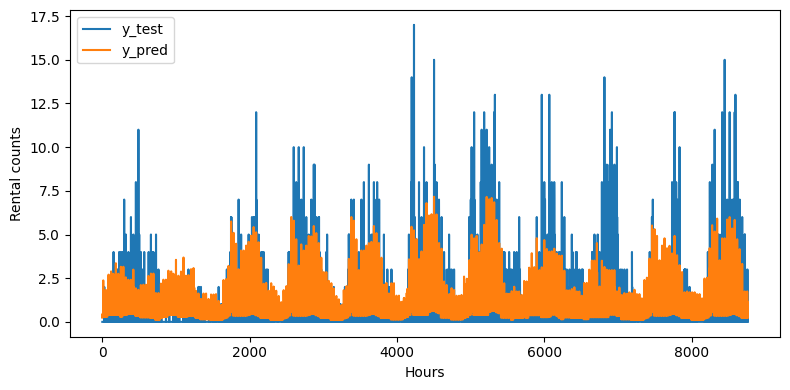

In [52]:
# Evaluate the model on X_test
y_pred = xgb_r.predict(X_test)
print(len(y_pred))
fig, ax = plt.subplots(figsize=(8, 4))
x = range(y_test.shape[0])

ax.plot(x, y_test, label='y_test')
ax.plot(x, y_pred, label='y_pred')
ax.set_ylabel('Rental counts')
ax.set_xlabel('Hours')
ax.legend()

plt.tight_layout()
plt.show()

In [54]:
X_test

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
26280,0.253863,0.935065,0.249071,0.126582,0.0,0.982963,0.629410,0.933013,0.75,0.697431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26281,0.253863,0.935065,0.249071,0.126582,0.0,0.982963,0.629410,0.933013,0.75,0.697431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26282,0.273731,0.922078,0.265799,0.159494,0.0,1.000000,0.500000,0.933013,0.75,0.697431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26283,0.273731,0.922078,0.265799,0.159494,0.0,1.000000,0.500000,0.933013,0.75,0.697431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26284,0.273731,0.922078,0.265799,0.159494,0.0,1.000000,0.500000,0.933013,0.75,0.697431,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,0.280353,0.870130,0.249071,0.356962,0.0,0.370590,0.982963,0.933013,0.75,0.826105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35036,0.280353,0.870130,0.249071,0.356962,0.0,0.370590,0.982963,0.933013,0.75,0.826105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35037,0.280353,0.870130,0.249071,0.356962,0.0,0.370590,0.982963,0.933013,0.75,0.826105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35038,0.280353,0.870130,0.249071,0.356962,0.0,0.370590,0.982963,0.933013,0.75,0.826105,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [141]:
print(len(y_pred))
y_new = y_pred[22:]
len(y_new)

297840


297818

In [142]:
297840/34

8760.0

In [60]:
y_new[:51]

array([0.29923138, 0.29923138, 1.1295867 , 0.5614333 , 0.33349073,
       0.4289491 , 0.29923138, 0.29923138, 0.29923138, 0.29923138,
       0.29923138, 0.29923138, 0.29923138, 0.29923138, 0.4649813 ,
       0.45651206, 0.29923138, 0.29923138, 0.32946584, 0.29923138,
       0.29923138, 0.29923138, 0.29923138, 0.29923138, 0.29923138,
       1.8311623 , 1.8100456 , 0.49234477, 0.4023869 , 1.6609535 ,
       0.3880655 , 0.29923138, 0.29923138, 0.29923138, 0.29923138,
       0.29923138, 1.2944016 , 0.5614333 , 0.33349073, 0.4289491 ,
       0.29923138, 0.29923138, 0.29923138, 0.29923138, 0.29923138,
       0.29923138, 0.29923138, 0.29923138, 0.58205724, 0.53228873,
       0.4163073 ], dtype=float32)

In [143]:
y_pred_new = np.reshape(y_pred, (8760, 34))
# print(len(y_pred_new))

In [144]:
# y_test_new = y_test[22:].to_numpy()
y_test_new = np.reshape(y_test.to_numpy(), (8760, 34))
len(y_test_new)

8760

In [63]:
len(np.reshape(y_new, (257, 34))[0])

34

In [67]:
print(type(y_new[:35]))
type(np.reshape(y_new, (257, 34))[0])

<class 'numpy.ndarray'>


numpy.ndarray

In [68]:
y_new[:34] == np.reshape(y_new, (257, 34))[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

8760


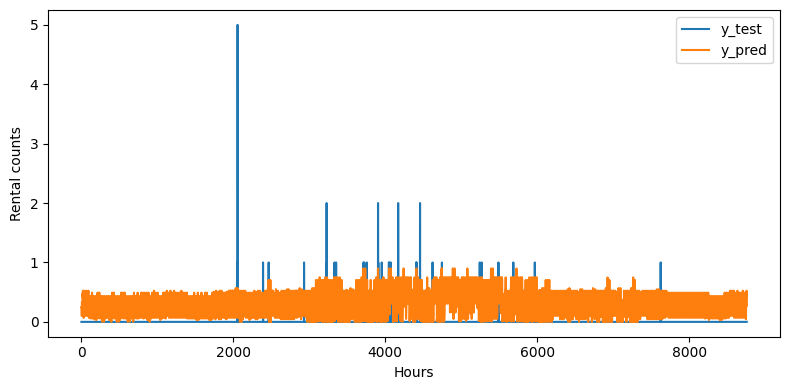

In [146]:
# Evaluate the model on X_test
# y_pred = xgb_r.predict(X_test)
print(len(y_pred_new))
fig, ax = plt.subplots(figsize=(8, 4))
x = range(y_test_new.shape[0])

ax.plot(x, y_test_new[:, 10], label='y_test')
ax.plot(x, y_pred_new[:, 10], label='y_pred')
ax.set_ylabel('Rental counts')
ax.set_xlabel('Hours')
ax.legend()

plt.tight_layout()
plt.show()

8760


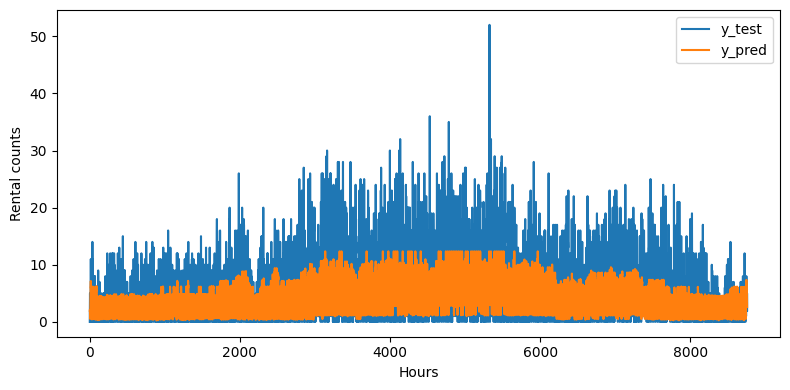

In [109]:
# Evaluate the model on X_test
# y_pred = xgb_r.predict(X_test)
print(len(y_pred_new))
fig, ax = plt.subplots(figsize=(8, 4))
x = range(y_test_new.shape[0])

ax.plot(x, y_test_new[:, 23], label='y_test')
ax.plot(x, y_pred_new[:, 23], label='y_pred')
ax.set_ylabel('Rental counts')
ax.set_xlabel('Hours')
ax.legend()

plt.tight_layout()
plt.show()

In [116]:
y_pred_new_df = pd.DataFrame(y_pred_new, columns=district_names)
y_pred_new_df.head(10)

,Altstadt-Lehel,Au - Haidhausen,Aubing-Lochhausen-Langwied,Berg am Laim,Bogenhausen,Feldmoching,Hadern,Harlaching,Hasenbergl-Lerchenau Ost,Laim,...,Schwanthalerhöhe,Sendling,Sendling-Westpark,Südgiesing,Thalkirchen,Trudering,Trudering-Riem,Untergiesing,Untergiesing-Harlaching,Untermenzing-Allach
0,1.819907,0.914342,0.612534,0.612534,0.612534,0.402739,0.612534,0.612534,0.448245,0.612534,...,0.612534,1.059585,0.612534,0.471320,0.612534,0.612534,0.612534,0.612534,0.612534,0.454325
1,1.819907,0.914342,0.612534,0.612534,0.612534,0.402739,0.612534,0.612534,0.448245,0.612534,...,0.612534,1.059585,0.612534,0.471320,0.612534,0.612534,0.612534,0.612534,0.612534,0.454325
2,1.523371,0.884283,0.582475,0.582475,0.582475,0.372680,0.582475,0.582475,0.418186,0.582475,...,0.582475,1.029526,0.582475,0.441261,0.582475,0.582475,0.582475,0.582475,0.582475,0.424266
3,1.184989,0.721652,0.244093,0.244093,0.244093,0.034298,0.244093,0.244093,0.234891,0.244093,...,0.244093,0.691144,0.244093,0.257966,0.244093,0.244093,0.244093,0.244093,0.244093,0.085884
4,1.184989,0.721652,0.244093,0.244093,0.244093,0.034298,0.244093,0.244093,0.234891,0.244093,...,0.244093,0.691144,0.244093,0.257966,0.244093,0.244093,0.244093,0.244093,0.244093,0.085884
5,1.184989,0.721652,0.244093,0.244093,0.244093,0.034298,0.244093,0.244093,0.234891,0.244093,...,0.244093,0.691144,0.244093,0.257966,0.244093,0.244093,0.244093,0.244093,0.244093,0.085884
6,1.255278,0.791940,0.314382,0.314382,0.314382,0.104587,0.314382,0.314382,0.234891,0.314382,...,0.314382,0.761432,0.314382,0.257966,0.314382,0.314382,0.314382,0.314382,0.314382,0.156172
7,1.308054,0.844716,0.367158,0.367158,0.367158,0.157363,0.367158,0.367158,0.135007,0.367158,...,0.367158,0.814208,0.367158,0.183354,0.367158,0.367158,0.367158,0.367158,0.367158,0.048267
8,1.794822,1.890567,0.853926,0.853926,0.853926,0.644131,0.853926,0.853926,0.536976,0.853926,...,0.853926,1.300976,0.853926,0.585323,0.853926,0.853926,0.853926,0.853926,0.853926,0.535035
9,1.794822,1.522993,0.853926,0.853926,0.853926,0.644131,0.853926,0.853926,0.536976,0.853926,...,0.853926,1.300976,0.853926,0.585323,0.853926,0.853926,0.853926,0.853926,0.853926,0.535035


<Axes: >

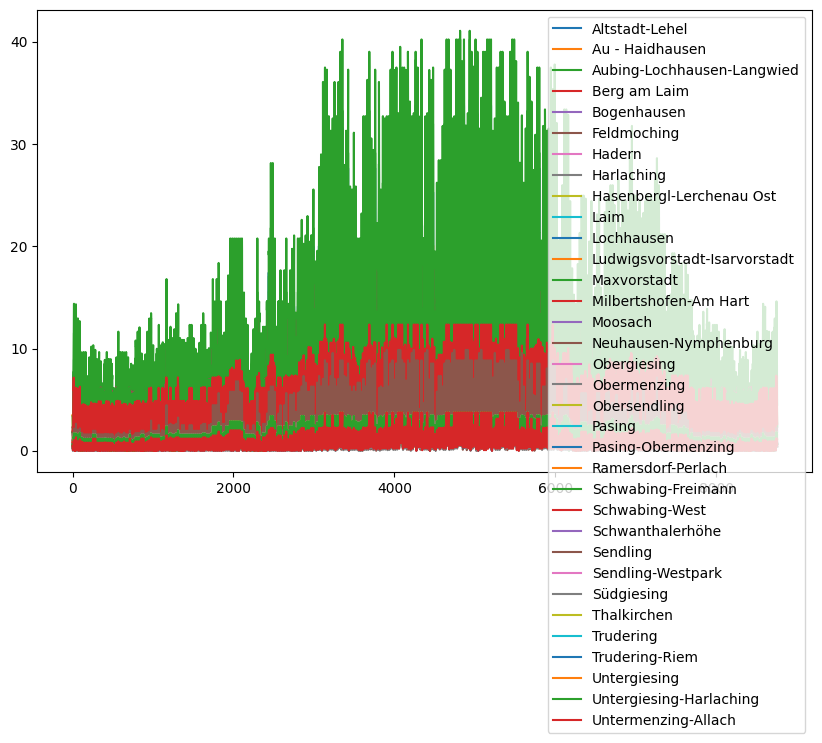

In [117]:
y_pred_new_df.plot(figsize = (10, 6))